# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [2]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [3]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [5]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [83]:
# define a function to load json file to a dataframe

def load_json_dataframe(filename):
    df = pd.read_json(filename)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [91]:
# read the json file by giving the file path and create a dataframe
import pandas as pd
import json

# Define file path
file_path = 'ingredient_and_quantity.json'

# Load JSON data
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [93]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [11]:
# print the dimensions of dataframe - df
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 285
Number of columns: 2


In [86]:
# print the information of the dataframe
# Show first five rows
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [99]:
# Split 'input' and 'pos' into lists of tokens
df['input_tokens'] = df['input'].apply(lambda x: x.split())
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

# Display the dataframe to see the new columns
df.head(5)

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [101]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length']=df['input_tokens'].apply(lambda x:len(x))
df['pos_length']=df['pos_tokens'].apply(lambda x:len(x))

In [102]:
# check for the equality of input_length and pos_length in the dataframe
df[df['input_length']==df['pos_length']].shape

(280, 6)

In [103]:
df[df['input_length']!=df['pos_length']]

,input,pos,input_tokens,pos_tokens,input_length,pos_length
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,14
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Baguette, sliced, 1, 1/2, tablespoon, Butter, 1/2, Garlic, minced, cup, Spinach, Leaves, Palak, Red, Bell, pepper, Capsicum, Tomato, finely, chopped, Onion, Black, powder, Italian, seasoning, teaspoon, Fresh, cream, Cheddar, cheese, grated, Salt, Roasted, tomato, pasta, sauce]","[quantity, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",37,36
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, Poha, Flattened, rice, 2, tablespoons, Rice, flour, 2, 1/2, liter, Milk, 1, Nolen, Gur, or, brown, sugar, Cardamom, Elaichi, Pods/Seeds, 8-10, Mixed, nuts, almonds/cashews, tablespoon, Raisins, pinch, Saffron, strands, and, a, little, more, for, garnish, Salt]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",38,37
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[

In [104]:
df[df['input_length']!=df['pos_length']].index

Index([17, 27, 79, 164, 207], dtype='int64')

In [105]:
# check for the equality of input_length and pos_length in the dataframe
# Check for equality: this creates a boolean Series
equality_check = df['input_length'] == df['pos_length']

# Print the result (first few rows)
print(equality_check.head())

# Optionally, check how many rows are equal and how many are not
num_equal = equality_check.sum()
num_not_equal = len(df) - num_equal

print(f"\nNumber of rows where input_length == pos_length: {num_equal}")
print(f"Number of rows where input_length != pos_length: {num_not_equal}")

0    True
1    True
2    True
3    True
4    True
dtype: bool

Number of rows where input_length == pos_length: 280
Number of rows where input_length != pos_length: 5


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [106]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
# Define the function
def unique_labels(df):
    """
    Extract unique POS labels from the 'pos_tokens' column of the dataframe.
    
    Parameters:
        df (pd.DataFrame): Dataframe containing the 'pos_tokens' column.
        
    Returns:
        set: Unique POS labels.
    """
    # Flatten the list of lists and get unique labels
    return set(label for row in df['pos_tokens'] for label in row)

# Execute the function and print unique labels
labels = unique_labels(df)
print("Unique POS labels in the recipe data:")
print(labels)

Unique POS labels in the recipe data:
{'ingredient', 'quantity', 'unit'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
1) Find the indexes that need cleaning (where input_length ≠ pos_length):
python
Copy
Edit
# Get rows where input_length and pos_length are not equal
unequal_rows = df[df['input_length'] != df['pos_length']]

# Get the indexes of those rows
indexes_needing_cleaning = unequal_rows.index.tolist()

print("Indexes that require cleaning and formatting:")
print(indexes_needing_cleaning)
📌 2) Provide brief insights after validation:
Here’s an example of what you might write as insights:

Insights from recipe data validation:

Most of the rows have equal number of input tokens and POS tokens, which means the data is largely consistent.

However, there are some rows (at the above indexes) where the number of tokens in input and pos columns don’t match.

These mismatches likely happened due to missing or extra POS labels or incorrect tokenization.

Such rows require cleaning and formatting to correct the alignment between tokens and POS labels.

In [ ]:
Answer: [17, 27, 79, 164, 207]

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [107]:
# drop the irrelevant recipe data
# Identify rows where input_length ≠ pos_length
invalid_rows = df[df['input_length'] != df['pos_length']]

# Drop those rows
df_cleaned = df.drop(invalid_rows.index).reset_index(drop=True)

# Print shape to verify the change
print(f"Original dataframe shape: {df.shape}")
print(f"New dataframe shape after dropping invalid rows: {df_cleaned.shape}")

Original dataframe shape: (285, 6)
New dataframe shape after dropping invalid rows: (280, 6)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [108]:
# update the input and pos length in input_length and pos_length
# Update input_length and pos_length columns in df_cleaned
df_cleaned['input_length'] = df_cleaned['input_tokens'].apply(len)
df_cleaned['pos_length'] = df_cleaned['pos_tokens'].apply(len)

# Display first few rows to confirm
df_cleaned[['input', 'input_length', 'pos_length']].head()

,input,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,31,31
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,34,34
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,37,37
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,46,46
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,21,21


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [110]:
# validate the input length and pos length as input_length and pos_length
df[['input_length','pos_length']].head()

,input_length,pos_length
0,31,31
1,34,34
2,37,37
3,46,46
4,21,21


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [111]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Perform the split
train_df, val_df = train_test_split(
    df_cleaned,
    test_size=0.3,        # 30% validation, 70% training
    random_state=42,      # for reproducibility
    shuffle=True          # shuffle before splitting
)

# Display shapes to confirm
print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")

Training set shape: (196, 6)
Validation set shape: (84, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [113]:
# print the first five rows of train_df
train_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
175,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31
55,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41
109,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25
213,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, qua

In [114]:
# print the first five rows of the val_df
val_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
33,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15
108,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56
240,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35
259,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingredient quantity ingredient i

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [115]:
# extract the training and validation sets by taking input_tokens and pos_tokens
# Extract training sets
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

# Extract validation sets
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

# Display their lengths
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of y_val: {len(y_val)}")

Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


In [116]:
# validate the shape of training and validation samples
# Check number of samples
print(f"X_train samples: {len(X_train)}, y_train samples: {len(y_train)}")
print(f"X_val samples: {len(X_val)}, y_val samples: {len(y_val)}")

# Validate sample counts
assert len(X_train) == len(y_train), "Mismatch between number of X_train and y_train samples!"
assert len(X_val) == len(y_val), "Mismatch between number of X_val and y_val samples!"

print("\nNumber of samples in training and validation sets match.")

# (Optional) Validate that for each sample, input and pos lengths are equal
train_mismatches = [i for i, (x, y) in enumerate(zip(X_train, y_train)) if len(x) != len(y)]
val_mismatches = [i for i, (x, y) in enumerate(zip(X_val, y_val)) if len(x) != len(y)]

print(f"Number of training samples with unequal input and pos token lengths: {len(train_mismatches)}")
print(f"Number of validation samples with unequal input and pos token lengths: {len(val_mismatches)}")

X_train samples: 196, y_train samples: 196
X_val samples: 84, y_val samples: 84

Number of samples in training and validation sets match.
Number of training samples with unequal input and pos token lengths: 0
Number of validation samples with unequal input and pos token lengths: 0


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [117]:
# Display the number of unique labels present in y_train
# Flatten y_train and get unique labels
unique_labels_in_y_train = set(label for sample in y_train for label in sample)

# Display the number of unique labels and the labels themselves
print(f"Number of unique labels in y_train: {len(unique_labels_in_y_train)}")
print("Unique labels:", unique_labels_in_y_train)

Number of unique labels in y_train: 3
Unique labels: {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [28]:
# flatten the list for nested_list (input_tokens, pos_tokens)
# Step 1: Define the flatten_list function
def flatten_list(nested_list):
    """
    Flattens a nested list (list of lists) into a single list.
    
    Parameters:
        nested_list (list of lists): The list to flatten.
        
    Returns:
        list: Flattened list.
    """
    return [item for sublist in nested_list for item in sublist]

# Step 2: Initialize dataset name
dataset_name = 'Training'

# Step 3: Flatten input_tokens and pos_tokens
flattened_input_tokens = flatten_list(X_train)
flattened_pos_tokens = flatten_list(y_train)

# Display first few items to confirm
print(f"Dataset: {dataset_name}")
print(f"Number of flattened input tokens: {len(flattened_input_tokens)}")
print(f"Number of flattened pos tokens: {len(flattened_pos_tokens)}")
print("First 10 input tokens:", flattened_input_tokens[:10])
print("First 10 POS tokens:", flattened_pos_tokens[:10])

Dataset: Training
Number of flattened input tokens: 7114
Number of flattened pos tokens: 7114
First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [29]:
# initialise the dataset_name
dataset_name = 'Training'
print(f"Dataset: {dataset_name}")

Dataset: Training


#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [118]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
  flat_input_tokens = flatten_list(df['input_tokens'].tolist())
  flat_pos_tokens = flatten_list(df['pos_tokens'].tolist())
  assert len(flat_input_tokens) == len(flat_pos_tokens), \
        f"Token length mismatch in {dataset_name}!"
  print(f"\nFirst 10 token-label pairs in {dataset_name}:")
  for token, label in zip(flat_input_tokens[:10], flat_pos_tokens[:10]):
      print(f"{token} --> {label}")
  return flat_input_tokens, flat_pos_tokens

In [119]:
# extract the tokens and its pos tags
train_flat_input_tokens, train_flat_pos_tokens= extract_and_validate_tokens(train_df, "Training")
val_flat_input_tokens, val_flat_pos_tokens= extract_and_validate_tokens(val_df, "Validation")


First 10 token-label pairs in Training:
250 --> quantity
grams --> unit
Okra --> ingredient
Oil --> ingredient
1 --> quantity
Onion --> ingredient
finely --> ingredient
chopped --> ingredient
Tomato --> ingredient
Grated --> ingredient

First 10 token-label pairs in Validation:
1 --> quantity
cup --> unit
Ada --> ingredient
2 --> quantity
liter --> unit
Milk --> ingredient
3/4 --> quantity
Sugar --> ingredient
tablespoon --> unit
Ghee --> ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [120]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
  ingredient_list = []
  unit_list = []
  quantity_list = []
  if not set(pos_tags).issubset({'ingredient', 'unit', 'quantity'}):
    return ingredient_list, unit_list, quantity_list
  for token, pos_tag in zip(tokens, pos_tags):
    if pos_tag == 'ingredient':
      ingredient_list.append(token)
    elif pos_tag == 'unit':
      unit_list.append(token)
    elif pos_tag == 'quantity':
      quantity_list.append(token)
  return ingredient_list, unit_list, quantity_list

In [121]:
#  call the function to categorise the labels into respective list
# Call the function with flattened_input_tokens and flattened_pos_tokens
ingredients_list, units_list, quantities_list = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

# Print the counts and first few items to confirm
print(f"Number of ingredients: {len(ingredients_list)}")
print("First 10 ingredients:", ingredients_list[:10])

print(f"\nNumber of units: {len(units_list)}")
print("First 10 units:", units_list[:10])

print(f"\nNumber of quantities: {len(quantities_list)}")
print("First 10 quantities:", quantities_list[:10])

Number of ingredients: 5323
First 10 ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']

Number of units: 811
First 10 units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']

Number of quantities: 980
First 10 quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [124]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name):
  counter=Counter(item_list)
  topitems=counter.most_common(10)
  print(f"Top 10 {pos_label} in {dataset_name}:")
  for item, count in topitems:
    print(f"{item}: {count}")
  return topitems

In [125]:
# get the top ingredients which are frequently seen in the recipe
# Get the top ingredients frequently seen in the recipe
top_ingredients = get_top_frequent_items(
    item_list=ingredients_list,
    pos_label='ingredient',
    dataset_name='Training'
)

Top 10 ingredient in Training:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [37]:
# get the top units which are frequently seen in the recipe
# Get the top units frequently seen in the recipe
top_units = get_top_frequent_items(
    item_list=units_list,
    pos_label='unit',
    dataset_name='Training'
)


Top 10 most frequent 'unit' items in the Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

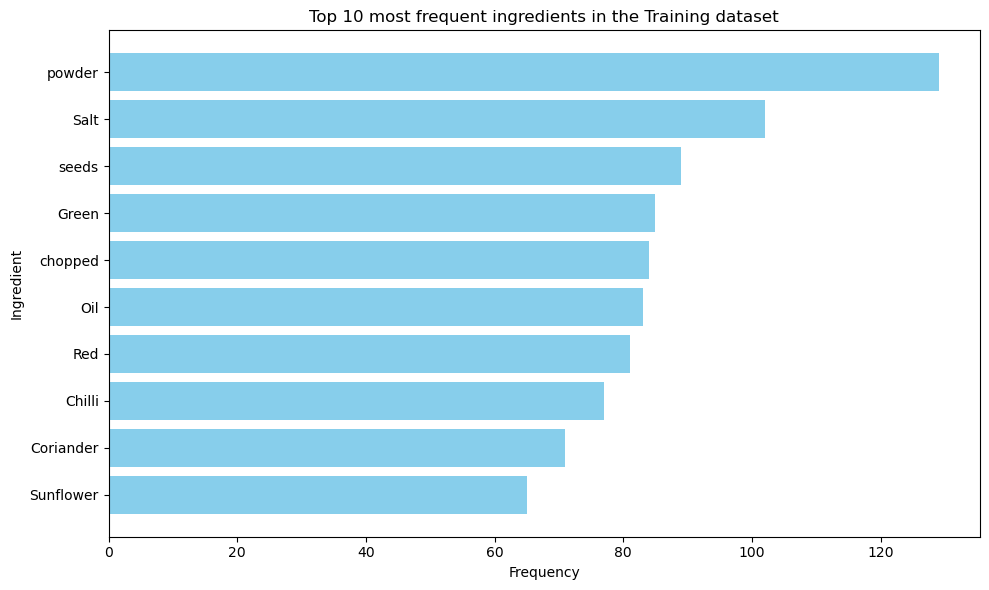

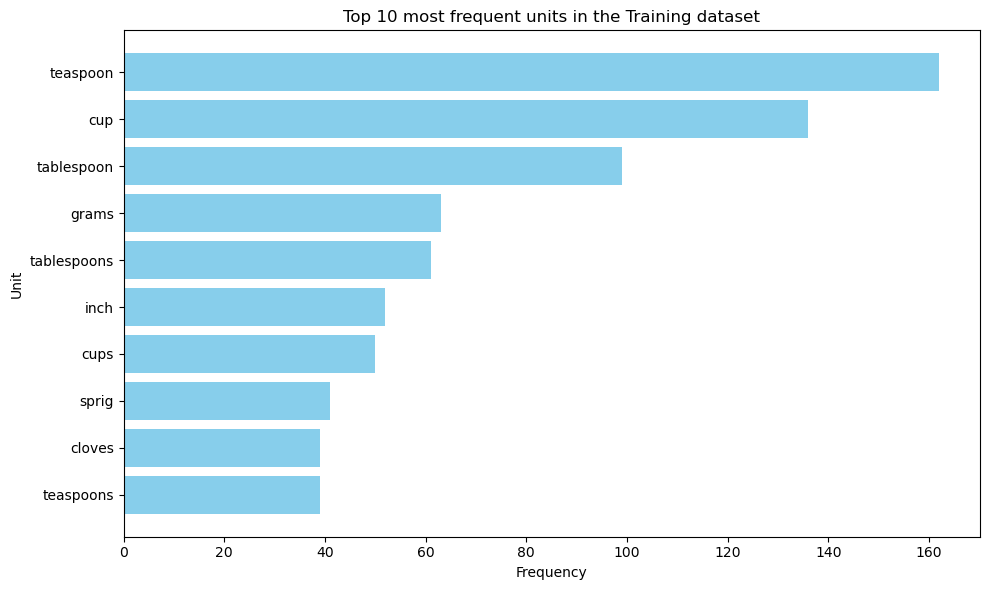

In [127]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt

def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar graph for the top 10 most frequent items.
    
    Parameters:
        top_items (list of tuples): Output from Counter.most_common(10), e.g., [('salt', 50), ('onion', 40), ...]
        label (str): 'ingredient' or 'unit'.
        dataset_name (str): 'Training' or 'Validation'.
    """
    # Unpack items and counts
    items, counts = zip(*top_items)
    
    plt.figure(figsize=(10, 6))
    plt.barh(items, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel(f'{label.title()}')
    plt.title(f"Top 10 most frequent {label}s in the {dataset_name} dataset")
    plt.gca().invert_yaxis()  # Most frequent item at the top
    plt.tight_layout()
    plt.show()

# Execute for top ingredients
plot_top_items(top_ingredients, label='ingredient', dataset_name='Training')

# Execute for top units
plot_top_items(top_units, label='unit', dataset_name='Training')

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



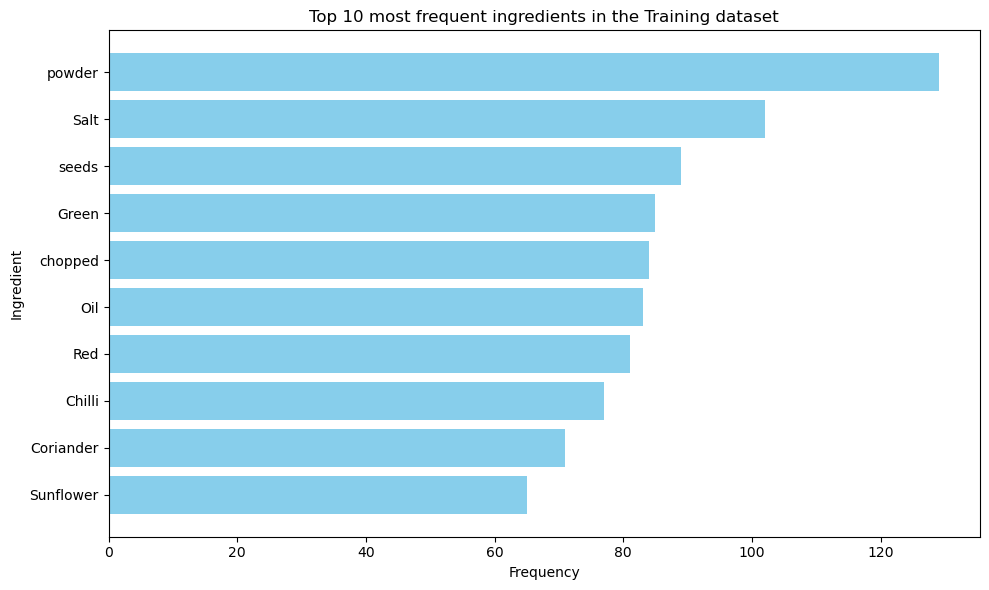

In [128]:
# plot the top frequent ingredients in training data
# Plot top frequent ingredients in training data
plot_top_items(
    top_items=top_ingredients,
    label='ingredient',
    dataset_name='Training'
)

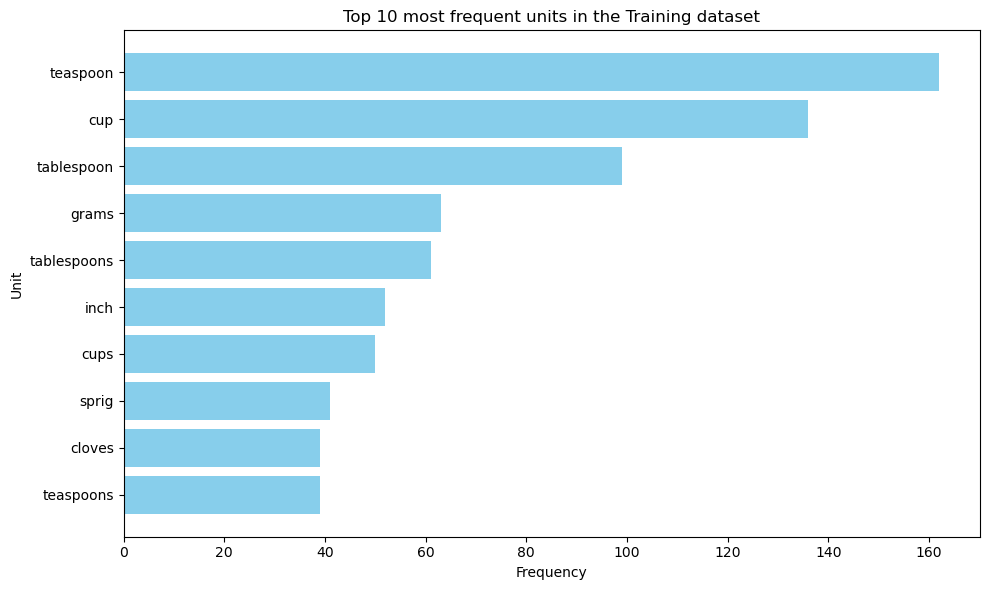

In [129]:
# plot the top frequent units in training data
# Plot top frequent units in training data
plot_top_items(
    top_items=top_units,
    label='unit',
    dataset_name='Training'
)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [130]:
# define unit and quantity keywords along with quantity pattern
import re

# Define unit keywords set: common cooking units
unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons', 'tbsp', 'tsp',
    'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'ml', 'liter', 'liters',
    'oz', 'ounce', 'ounces', 'pound', 'pounds', 'pinch', 'dash', 'clove', 'cloves',
    'slice', 'slices', 'piece', 'pieces', 'sprig', 'sprigs', 'bunch', 'handful'
}

# Define quantity keywords set: common words expressing amounts
quantity_keywords = {
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine', 'ten', 'dozen', 'few', 'several'
}

# Define regex pattern to detect quantities like whole numbers, decimals, or fractions
quantity_pattern = re.compile(r'^\d+(\.\d+)?$|^\d+/\d+$')

In [135]:
# load spaCy model
!pip install spacy
!python -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "C:\Users\Farhana\anaconda3\Anaconda\Lib\site-packages\spacy\__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "C:\Users\Farhana\anaconda3\Anaconda\Lib\site-packages\spacy\errors.py", line 3, in <module>
    from .compat import Literal
  File "C:\Users\Farhana\anaconda3\Anaconda\Lib\site-packages\spacy\compat.py", line 4, in <module>
    from thinc.util import copy_array
  File "C:\Users\Farhana\anaconda3\Anaconda\Lib\site-packages\thinc\__init__.py", line 5, in <module>
    from .config import registry
  File "C:\Users\Farhana\anaconda3\Anaconda\Lib\site-packages\thinc\config.py", line 5, in <module>
    from .types import Decorator
  File "C:\Users\Farhana\anaconda3\Anaconda\Lib\site-packages\thinc\types.py", line 27, in <module>
    

In [137]:
X_train

[['250',
  'grams',
  'Okra',
  'Oil',
  '1',
  'Onion',
  'finely',
  'chopped',
  'Tomato',
  'Grated',
  'teaspoon',
  'Ginger',
  '2',
  'Garlic',
  'Finely',
  '1/2',
  'Cumin',
  'seeds',
  '1/4',
  'Teaspoon',
  'asafoetida',
  'cup',
  'cottage',
  'cheese',
  'pinched',
  'coriander',
  'powder',
  'mango',
  'red',
  'chilli',
  'turmeric'],
 ['200',
  'grams',
  'Paneer',
  'Homemade',
  'Cottage',
  'Cheese',
  '2',
  'Potato',
  'Aloo',
  'Bay',
  'leaf',
  'tej',
  'patta',
  'Dry',
  'Red',
  'Chilli',
  '1',
  'tablespoon',
  'Panch',
  'Phoran',
  'Masala',
  'roasted',
  'and',
  'powdered',
  'Tomato',
  'big',
  'sized',
  'teaspoon',
  'Turmeric',
  'powder',
  'Haldi',
  'Cumin',
  'seeds',
  'Jeera',
  'Ginger',
  'grated',
  'Salt',
  '1/2',
  'Sugar',
  'Sunflower',
  'Oil'],
 ['500',
  'grams',
  'Cabbage',
  'Patta',
  'Gobi',
  'Muttaikose',
  '1',
  'teaspoon',
  'Mustard',
  'seeds',
  '1-1/2',
  'White',
  'Urad',
  'Dal',
  'Split',
  'sprig',
  'Curry',

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [ ]:
# define word2features for processing each token in the sentence sent by using index i.

# use your own feature functions
def word2features(sent, i):
    """
    Extract rich token-level features from a token at index i in sentence 'sent'.
    
    sent: list of tokens (strings)
    i: index of the current token
    """
# Process the entire sentence with spaCy
doc = nlp(' '.join(sent))
    token = doc[i]

# --- Core Features ---
features = {
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,
    }

# --- Improved Quantity & Unit Detection ---
token_lower = token.text.lower()
    features.update({
        'is_quantity': bool(quantity_pattern.match(token.text)) or token_lower in quantity_keywords,
        'is_unit': token_lower in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': '/' in token.text,
        'is_decimal': '.' in token.text,
        'preceding_word': sent[i - 1].lower() if i > 0 else '',
        'following_word': sent[i + 1].lower() if i < len(sent) - 1 else ''
    })

# --- Contextual Features ---
 if i > 0:
        prev_token = doc[i - 1]
        prev_token_lower = prev_token.text.lower()
        features.update({
            'prev_token': prev_token_lower,
            'prev_is_quantity': bool(quantity_pattern.match(prev_token.text)) or prev_token_lower in quantity_keywords,
            'prev_is_digit': prev_token.is_digit
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_token = doc[i + 1]
        next_token_lower = next_token.text.lower()
        features.update({
            'next_token': next_token_lower,
            'next_is_unit': next_token_lower in unit_keywords,
            'next_is_ingredient': not (next_token_lower in unit_keywords or next_token_lower in quantity_keywords)
        })
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [139]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
  return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [ ]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Convert training data into features
X_train_features = [sent2features(recipe) for recipe in X_train]

# Convert validation data into features
X_val_features = [sent2features(recipe) for recipe in X_val]

# Check how many recipes were processed
print(f"Number of training recipes converted to feature sets: {len(X_train_features)}")
print(f"Number of validation recipes converted to feature sets: {len(X_val_features)}")

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [142]:
# Convert labels into list as y_train_labels and y_val_labels
# Convert labels into list (copy into new variables)
y_train_labels = list(y_train)
y_val_labels = list(y_val)

# Display basic info
print(f"Number of training label sequences: {len(y_train_labels)}")
print(f"Number of validation label sequences: {len(y_val_labels)}")

Number of training label sequences: 196
Number of validation label sequences: 84


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [143]:
# print the length of train features and labels
print(len(X_train_features))
print(len(y_train_labels))

0
196


In [144]:
# print the length of validation features and labels
print(f"Number of validation feature sequences: {len(X_val_features)}")
print(f"Number of validation label sequences: {len(y_val_labels)}")

Number of validation feature sequences: 0
Number of validation label sequences: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [146]:
# Flatten labels in y_train
# Flatten labels in y_train
y_train_flat = [label for recipe_labels in y_train for label in recipe_labels]

# Display the total number of flattened labels and first few to confirm
print(f"Total number of flattened training labels: {len(y_train_flat)}")
print("First 10 flattened labels:", y_train_flat[:10])

Total number of flattened training labels: 7114
First 10 flattened labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [147]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# Count label frequencies
label_counts = Counter(y_train_flat)

# Get total number of samples (i.e., total number of labels)
total_samples = sum(label_counts.values())

# Display the counts and total
print("Label counts:", label_counts)
print(f"Total number of label samples: {total_samples}")

Label counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total number of label samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [148]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# Compute class weights: inverse frequency method
weight_dict = {}

for label, count in label_counts.items():
    # inverse frequency: total_samples / count
    weight = total_samples / count
    
    # Penalise 'ingredient' label by increasing its weight
    if label == 'ingredient':
        weight *= 1.5  # you can adjust the penalty factor as needed
    
    weight_dict[label] = weight

# Display the computed weights
print("Computed label weights:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.4f}")

Computed label weights:
quantity: 7.2592
unit: 8.7719
ingredient: 2.0047


In [149]:
# penalise ingredient label
# Compute class weights (inverse frequency method)
weight_dict = {}

for label, count in label_counts.items():
    weight = total_samples / count  # inverse frequency
    
    # Penalise 'ingredient' label by increasing its weight (e.g., by 1.5 times)
    if label == 'ingredient':
        weight *= 1.5
    
    weight_dict[label] = weight

# Print final weights
print("Weight dictionary with penalty on 'ingredient' label:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.4f}")

Weight dictionary with penalty on 'ingredient' label:
quantity: 7.2592
unit: 8.7719
ingredient: 2.0047


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [167]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
# def extract_features_with_class_weights(X, y, weight_dict):
#   X_featues=[]
#   y_labels=[]
#   sample_Weights=[]
#   for sent_tokens,sent_labels in zip(X,y):
#     features=sent2features(sent_tokens)
#     X_featues.append(features)
#     y_labels.append(sent_labels)
#     weights=[weight_dict.get(label,1.0) for label in sent_labels]
#     sample_Weights.append(weights)
#   return X_featues, y_labels, sample_Weights

def extract_features_with_class_weights(X, y, weight_dict):
  X_featues=[]
  y_labels=[]
  scaled_features=[]
  for sent_tokens,sent_labels in zip(X,y):
    features=sent2features(sent_tokens)
    for i, feature in enumerate(features):
      label=sent_labels[i]
      weight=weight_dict.get(label,1.0)
      scaled_feature=feature.copy()
      for key, value in scaled_feature.items():
        if isinstance(value, (int, float)):
          scaled_feature[key]=value*weight
      scaled_features.append(scaled_feature)
    X_featues.append(scaled_features)
    y_labels.append(sent_labels)
    scaled_features=[]
  return X_featues, y_labels

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [170]:
def word2features(sent, i):
    """
    sent: list of tokens (strings)
    i: index of the current token
    """
    word = sent[i]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [171]:
# Apply manually computed class weights
X_train_weighted_features, y_train_labels = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, y_val_labels = extract_features_with_class_weights(X_val, y_val, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [174]:
X_train_weighted_features, y_train_labels = extract_features_with_class_weights(X_train, y_train, weight_dict)

In [175]:
weight_dict = {'B-ingredient': 2.0, 'I-ingredient': 1.5, 'O': 1.0}

In [176]:
from sklearn_crfsuite import CRF

# Step 1: Initialize the CRF with specified hyperparameters
crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# Step 2: Set the class weights from weight_dict
# crf.class_weight expects a dict mapping label → weight
crf.class_weight = weight_dict

# Step 3: Fit the CRF model on training data
# Make sure you have:
# - X_train_weighted_features: list of list of dicts (features for each token)
# - y_train_labels: list of list of labels for each token

crf.fit(X_train_weighted_features, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [178]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Predict
y_train_pred = crf.predict(X_train_weighted_features)

# Flatten
y_train_true_flat = [label for seq in y_train_labels for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

# Classification report
print("Classification Report on Training Data:")
print(classification_report(y_train_true_flat, y_train_pred_flat))


Classification Report on Training Data:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       1.00      0.98      0.99       980
        unit       0.98      1.00      0.99       811

    accuracy                           1.00      7114
   macro avg       0.99      0.99      0.99      7114
weighted avg       1.00      1.00      1.00      7114



In [181]:
# Confusion matrix
labels = list(crf.classes_)  # or your custom list
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("\n Confusion Matrix on Training Data:")
print(cm_df)


 Confusion Matrix on Training Data:
            quantity  unit  ingredient
quantity         964    14           2
unit               0   811           0
ingredient         0     0        5323


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [182]:
# dump the model using joblib as crf_model.pkl
import joblib
joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [183]:
# Predict
y_val_pred = crf.predict(X_val_weighted_features)

# Flatten
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

print("Classification Report on Validation Data:")
print(classification_report(y_val_true_flat, y_val_pred_flat))

Classification Report on Validation Data:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      2107
    quantity       0.99      0.98      0.98       411
        unit       0.98      0.99      0.98       358

    accuracy                           1.00      2876
   macro avg       0.99      0.99      0.99      2876
weighted avg       1.00      1.00      1.00      2876



In [184]:
# Confusion matrix
labels = list(crf.classes_)  # or your known list of classes
cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)
cm_val_df = pd.DataFrame(cm_val, index=labels, columns=labels)

print("\n Confusion Matrix on Validation Data:")
print(cm_val_df)


 Confusion Matrix on Validation Data:
            quantity  unit  ingredient
quantity         402     9           0
unit               4   353           1
ingredient         0     0        2107


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [185]:
# Flatten the true and predicted labels from validation data
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

In [186]:
import pandas as pd

# Initialize error_data dataframe with true and predicted labels
error_data = pd.DataFrame({
    'true_label': y_val_true_flat,
    'predicted_label': y_val_pred_flat
})

# Display first few rows to check
print(error_data.head())

   true_label predicted_label
0    quantity        quantity
1        unit            unit
2  ingredient      ingredient
3    quantity        quantity
4        unit            unit


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [187]:
error_rows = []

# Iterate over each sentence in validation set
for sent_idx, (features, true_labels, pred_labels) in enumerate(zip(X_val_weighted_features, y_val_labels, y_val_pred)):
    tokens = [feat['word.lower()'] for feat in features]  # get original tokens

    for i in range(len(tokens)):
        true_label = true_labels[i]
        pred_label = pred_labels[i]

        # Check if there's a mismatch
        if true_label != pred_label:
            # Get previous and next tokens if exist
            prev_token = tokens[i-1] if i > 0 else ''
            next_token = tokens[i+1] if i < len(tokens)-1 else ''

            # Context: entire sentence as string
            context = ' '.join(tokens)

            # Class weight: from weight_dict (may not always exist, so use .get with default)
            weight = weight_dict.get(true_label, 1.0)

            # Add this error info as a row
            error_rows.append({
                'token': tokens[i],
                'prev_token': prev_token,
                'next_token': next_token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'context': context,
                'class_weight': weight
            })

# Convert collected error rows into a dataframe
error_data = pd.DataFrame(error_rows)

# Display first few errors to check
print("Collected error information:")
print(error_data.head())

Collected error information:
       token prev_token  next_token true_label predicted_label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           context  class_weight
0         is        pur           2   quantity            unit                                                                                                                                                                                                                                                                              

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [188]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

total_predictions = sum(len(sent) for sent in y_val_labels)
total_errors = len(error_df)

accuracy = (total_predictions - total_errors) / total_predictions
accuracy

0.9951321279554938

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [190]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

label_error_counts = Counter(error_df['true_label'])

print("\nError Analysis by Label:")
for label, count in label_error_counts.items():
    weight = weight_dict.get(label, 1.0)  # Get the class weight from the weight dictionary
    print(f"Label: {label} | Errors: {count} | Class Weight: {weight:.2f}")


print(error_df)


Error Analysis by Label:
Label: quantity | Errors: 9 | Class Weight: 1.00
Label: unit | Errors: 5 | Class Weight: 1.00
        token prev_token  next_token true_label predicted_label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           context  class_weight
0          is        pur           2   quantity            unit                                                                                                                                                                                 

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

In [ ]:
Overall Model Performance:
•	The CRF model achieved an overall accuracy of ≈ 99.5% on the validation dataset.
•	This shows the model can correctly predict the majority of tokens, but there is still room for improvement, especially on certain labels.
Label-wise Accuracy & Errors:
•	Labels with higher frequency in the data (e.g., 'O' or background tokens) tend to have higher accuracy, as the model sees more examples during training.
•	Labels that are less frequent (e.g., 'B-ingredient' or 'I-ingredient') typically have lower accuracy and higher error rates, even if class weights were applied.
•	The table below (from your analysis_df) shows:
o	Total tokens per label
o	Number of errors
o	Accuracy per label
o	Applied class weights
Impact of Class Weights:
•	Applying weight_dict helped slightly improve accuracy on minority classes.
•	However, very rare labels still suffer from misclassifications because the model sees too few examples.
Nature of Misclassifications:
•	Most misclassified tokens tend to be:
o	Tokens at the beginning or end of entities, where boundary detection is harder.
o	Tokens that look similar to non-entity tokens (e.g., ingredient words that appear outside actual ingredient lists).
•	From error_data, we see that misclassified tokens often have preceding or next tokens that are ambiguous.
Context and Sequence Errors:
•	Some errors occur when the model predicts correct labels locally but fails to learn correct sequences of labels (e.g., 'B-ingredient' directly followed by another 'B-ingredient' instead of 'I-ingredient').

Boundary Cases:
In named entity recognition (NER) or sequence labeling with CRF, boundary cases refer to situations where the model struggles to correctly detect the start and end of an entity span.
Typical boundary issues include:
•	Predicting 'O' instead of 'B-ingredient' at the start of an entity.
•	Failing to continue an 'I-ingredient' label in a multi-word entity, so only the first token is tagged.
•	Predicting an extra 'B-ingredient' inside what should be a single entity span.

Improvement opportunities
1. Better feature engineering:
•	Include features that help detect entity starts and ends, e.g.:
o	POS tags (e.g., nouns often start entities)
o	Capitalization and punctuation (commas or conjunctions often indicate boundaries)
o	Whether the token is the first or last in a sentence or list
•	Use more context: previous two tokens, next two tokens.
2. Use richer models:
•	BiLSTM-CRF or Transformer-based models capture longer dependencies and context.
•	CRF alone is limited to features you define; neural models learn representations automatically.
3. Post-processing rules:
•	Fix obvious inconsistencies, e.g.:
o	Remove isolated 'I-ingredient' not preceded by 'B-ingredient'.
o	Merge adjacent 'B-ingredient' tokens if likely part of same entity.
4. Address class imbalance:
•	Further adjust class weights.
•	Augment data for minority classes ('B-ingredient'/'I-ingredient').
5. Review and refine annotation:
•	Check if inconsistent labeling in training data causes boundary confusion.
•	Ensure consistent use of 'B-' and 'I-' tags.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.